# Function calling using ScaDS.AI's LLM service
In this notebook we will do _function calling_ using a remote institutional server and the OpenAI API. For executing this notebook, you need an environment variable named `SCADSAI_API_KEY`. You can get such a key [here](https://llm.scads.ai/).

See also:
* [Open AI Documentation: function calling](https://platform.openai.com/docs/guides/function-calling)

In [1]:
import os
import openai
import json

These helper functions are stored in [function_calling_scadsai.py](function_calling_scadsai.py) and not shown for the readers convenience.

In [2]:
from function_calling_scadsai import function_to_dict, act

## Defining function tools
The following two functions will serve as functions the model can call. We also define some image memory, we can manage using the functions.

In [3]:
image_memory = {}

In [4]:
tools = []

@tools.append
def load_image(filename:str, image_name:str):
    """
    Loads an image from disk and stores it under a specified name
    """
    from skimage.io import imread
    image = imread(filename)
    # store the image in memory
    image_memory[image_name] = image
    
@tools.append
def show_image(image_name:str):
    """
    Shows an image specified by a name
    """
    from stackview import imshow
    imshow(image_memory[image_name])

@tools.append
def bake_cake(amount:int):
    """Bake cake for a given number of people."""
    pass

## Function calling using prompts
With this list of tools and a prompt that allows deciding which function to call, a large language model is capable of making the decision which function(s) to call.

First, we use the OpenAI API with their endpoint to see how it is supposed to work:

In [5]:
act("Load the image data/membranes.tif and store it as membrane", tools)

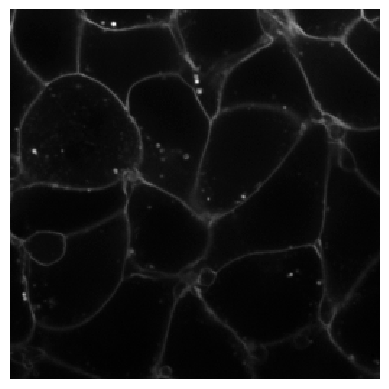

In [6]:
act("Visualize the `membrane` image", tools)

## How it works
Under the hood, the list of functions is converted to a list of dictionaries, where each dictionary describes a function.

In [7]:
tools_dicts = [function_to_dict(t) for t in tools]
tools_dicts

[{'type': 'function',
  'function': {'name': 'load_image',
   'description': 'Loads an image from disk and stores it under a specified name',
   'parameters': {'type': 'object',
    'properties': {'filename': {'type': 'string'},
     'image_name': {'type': 'string'}},
    'required': ['filename', 'image_name']}}},
 {'type': 'function',
  'function': {'name': 'show_image',
   'description': 'Shows an image specified by a name',
   'parameters': {'type': 'object',
    'properties': {'image_name': {'type': 'string'}},
    'required': ['image_name']}}},
 {'type': 'function',
  'function': {'name': 'bake_cake',
   'description': 'Bake cake for a given number of people.',
   'parameters': {'type': 'object',
    'properties': {'amount': {'type': 'integer'}},
    'required': ['amount']}}}]

We can pass this complex data structure to the LLM remove server as `tools` and the response

In [8]:
client = openai.OpenAI(base_url="https://llm.scads.ai/v1",
                       api_key=os.environ.get('SCADSAI_API_KEY'))

response = client.chat.completions.create(
    model="meta-llama/Llama-3.3-70B-Instruct",
    messages=[{"role": "user", "content": "Let's bake some cake for my four friends."}],
    tools=tools_dicts,
)
response

ChatCompletion(id='1a1858bc-d193-4bed-9bc5-f74ceb7a197d', choices=[Choice(finish_reason='stop', index=0, logprobs=None, message=ChatCompletionMessage(content=None, refusal=None, role='assistant', audio=None, function_call=None, tool_calls=[ChatCompletionMessageToolCall(id='0', function=Function(arguments='{"amount": 4}', name='bake_cake', description=None), type='function')]))], created=1740497928, model='meta-llama/Llama-3.3-70B-Instruct', object='chat.completion', service_tier=None, system_fingerprint='3.1.0-sha-463228e', usage=CompletionUsage(completion_tokens=19, prompt_tokens=525, total_tokens=544, completion_tokens_details=None, prompt_tokens_details=None))

From the response we can derive the function that should be called ...

In [9]:
response.choices[0].message.tool_calls[0].function.name

'bake_cake'

... and the parameters that should be passed to the function.

In [10]:
json.loads(response.choices[0].message.tool_calls[0].function.arguments)

{'amount': 4}

## Exercise
Think of things you often do in Python, e.g. copying a file from A to B. Write a python function which does it automatically and has a nicely explained documentation in the docstring. Then use the strategy shown above to instruct the LLM to use your function. Example:
```
act("Copy the file data/blobs.tif to ./blobs2.tif", tools)
```